In [1]:
import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
# cpu-gpu
a = torch.randn((3, 4))
print(a.device)

device = torch.device("cuda")
a = a.to(device)
print(a.device)

# a more generic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!nvidia-smi

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

In [ ]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [ ]:
class CNN_model(torch.nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 500)
        self.linear_2 = torch.nn.Linear(500, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        pred = self.linear_2(x)

        return pred

In [ ]:
model = CNN_model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=30000, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=500, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=4500, shuffle=False)

In [ ]:
no_epochs = 20
train_loss = list()
val_loss = list()
pred_accuracy = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    
    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):
        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)
    pred_accuracy.append(accuracy)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(4, 4))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.savefig('loss.png')


fig=plt.figure(figsize=(4, 4))
plt.plot(np.arange(1, no_epochs+1), pred_accuracy, label="Prediction accuracy")
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.title("Accuracy plot")
plt.legend(loc='upper right')
plt.savefig('accuracy.png')

In [ ]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    pred = model(img)
    pred = torch.nn.functional.softmax(pred, dim=1)
    plt.imshow(img)
    plt.title("Prediction: "+ pred)
plt.show()

In [ ]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)


Epoch: 1/20, Train Loss: 0.14993930, Val Loss: 0.04418621, Val Accuracy: 0.98566667
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.04418621

Epoch: 2/20, Train Loss: 0.04435618, Val Loss: 0.03841449, Val Accuracy: 0.98777778
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03841449

Epoch: 3/20, Train Loss: 0.03039658, Val Loss: 0.02624442, Val Accuracy: 0.99177778
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02624442

Epoch: 4/20, Train Loss: 0.01995129, Val Loss: 0.02946928, Val Accuracy: 0.99033333

Epoch: 5/20, Train Loss: 0.01625907, Val Loss: 0.03839264, Val Accuracy: 0.98866667

Epoch: 6/20, Train Loss: 0.01111933, Val Loss: 0.04059754, Val Accuracy: 0.98866667

Epoch: 7/20, Train Loss: 0.01052399, Val Loss: 0.03934832, Val Accuracy: 0.98722222

Epoch: 8/20, Train Loss: 0.00896726, Val Loss: 0.02537464, Val Accuracy: 0.99322222
Saving the model state dictionary for Epoch: 8 with Validation loss: 0.02537464


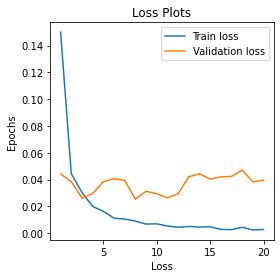

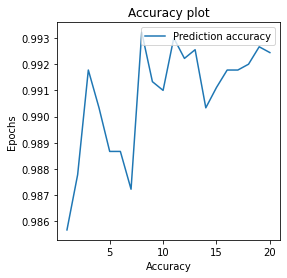

In [6]:
no_epochs = 20
train_loss = list()
val_loss = list()
pred_accuracy = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    
    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):
        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)
    pred_accuracy.append(accuracy)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(4, 4))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.savefig('loss.png')


fig=plt.figure(figsize=(4, 4))
plt.plot(np.arange(1, no_epochs+1), pred_accuracy, label="Prediction accuracy")
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.title("Accuracy plot")
plt.legend(loc='upper right')
plt.savefig('accuracy.png')